### Exercise 1.1


In [25]:
# all imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
# import os 
from IPython.display import Image, display
from PIL import Image as PILImage
import io


In [26]:
L=1
c=1
dt=0.001
N=200
dx=L/N
x=np.linspace(0, L, N+1)


In [27]:
def wav(psi, T, dt=dt, dx=dx, c=c):
    N = len(psi)-1
    r= c* (dt/dx)
    r2=r**2
    n_steps = int(T/dt)
    # psi vector at 3 consecutive time steps initialized
    psi_prev = np.copy(psi)
    psi_curr = np.copy(psi)
    psi_next = np.zeros_like(psi)
    # first step using taylor expansion
    for i in range(1,N):
        psi_next[i]= psi_curr[i]+0.5*r2*(psi_curr[i+1]+psi_curr[i-1]-2*psi_curr[i])
    psi_next[0]=0
    psi_next[N]=0
    times = [0]
    states=[np.copy(psi)]
    psi_prev=np.copy(psi_curr)
    psi_curr=np.copy(psi_next)
    times.append(dt)
    states.append(np.copy(psi_curr))
        
    # main loop after first step    
    for s in range(2, n_steps+1):
        for i in range(1,N):
            psi_next[i]=(r2*(psi_curr[i+1]+psi_curr[i-1]-2*psi_curr[i])+2*psi_curr[i]-psi_prev[i])
        psi_next[0]=0
        psi_next[N]=0
        psi_prev[:]=psi_curr
        psi_curr[:]=psi_next
        times.append(s*dt)
        states.append(np.copy(psi_curr))
                
    return times, states

In [28]:
#(a)
psi_a = np.sin(2*np.pi*x)
psi_a[0] = 0
psi_a[N] = 0

#(b)
psi_b = np.sin(5*np.pi*x)
psi_b[0]=0
psi_b[N]=0

#(c)
psi_c = np.zeros(N+1)
for i in range(N+1):
    if 1/5 < x[i] < 2/5:
        psi_c[i]= np.sin(5*np.pi*x[i])


T_end = 2

times_a, states_a = wav(psi_a, T_end)    
times_b, states_b = wav(psi_b, T_end)   
times_c, states_c = wav(psi_c, T_end) 

In [29]:
snap_times = [0.0, 0.1, 0.25, 0.5, 0.75, 1.0] 
colors = plt.cm.viridis(np.linspace(0, 1, len(snap_times)))

# output_dir = "outputs_1.1"
# os.makedirs(output_dir, exist_ok=True)

cases = [
    (times_a, states_a, r"(i) $\Psi(x,0) = \sin(2\pi x)$", "case_a"),
    (times_b, states_b, r"(ii) $\Psi(x,0) = \sin(5\pi x)$", "case_b"),
    (times_c, states_c, r"(iii) $\Psi(x,0) = \sin(5\pi x)$ on $(1/5,2/5)$", "case_c"),
]

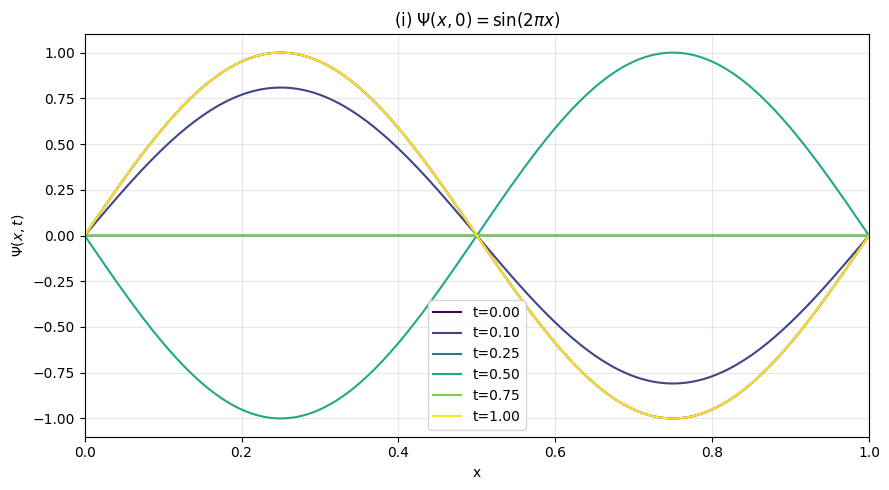

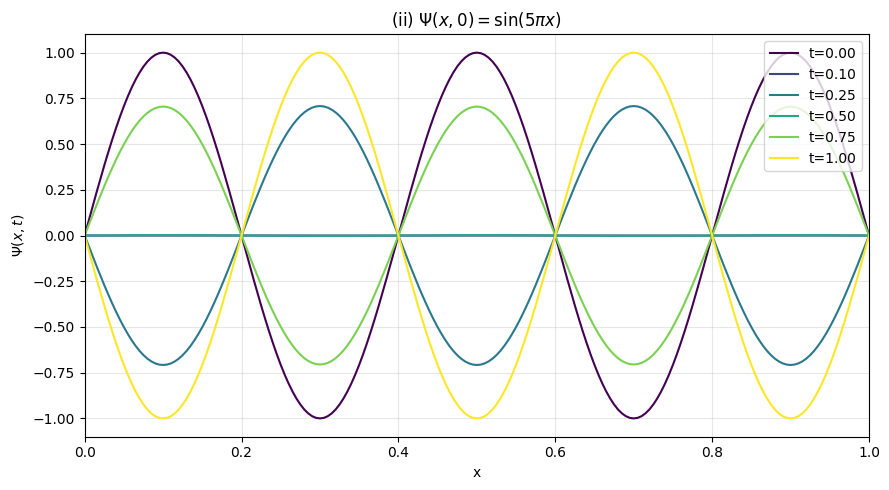

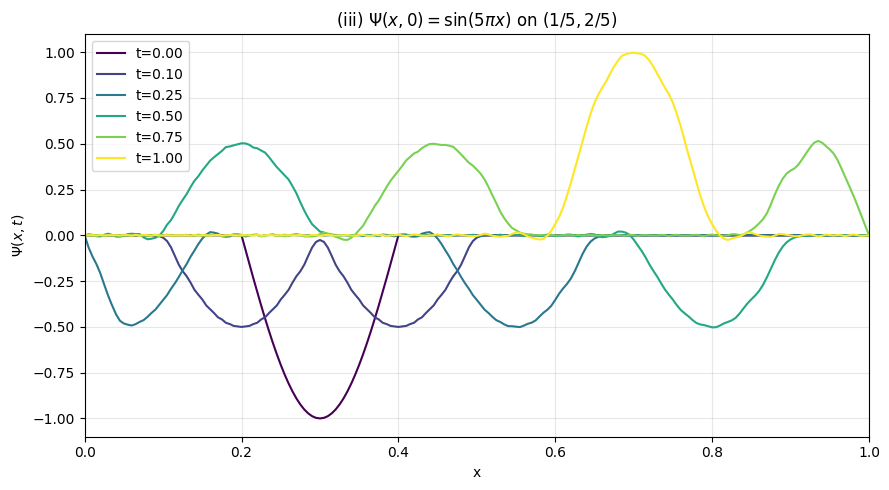

In [30]:
for t_list, s_list, title, name in cases:
    fig, ax = plt.subplots(figsize=(9, 5))
    for j, t_snap in enumerate(snap_times):
        idx = min(range(len(t_list)), key=lambda k: abs(t_list[k]-t_snap))
        ax.plot(x, s_list[idx], color=colors[j], label=f"t={t_list[idx]:.2f}")
    ax.set_xlabel("x")
    ax.set_ylabel(r"$\Psi(x,t)$")
    ax.set_title(title)
    ax.legend()
    ax.set_xlim(0, L)
    ax.grid(alpha=0.3)
    plt.tight_layout()
    # plt.savefig(os.path.join(output_dir, f"{name}_snap.png"), dpi=150)
    plt.show()

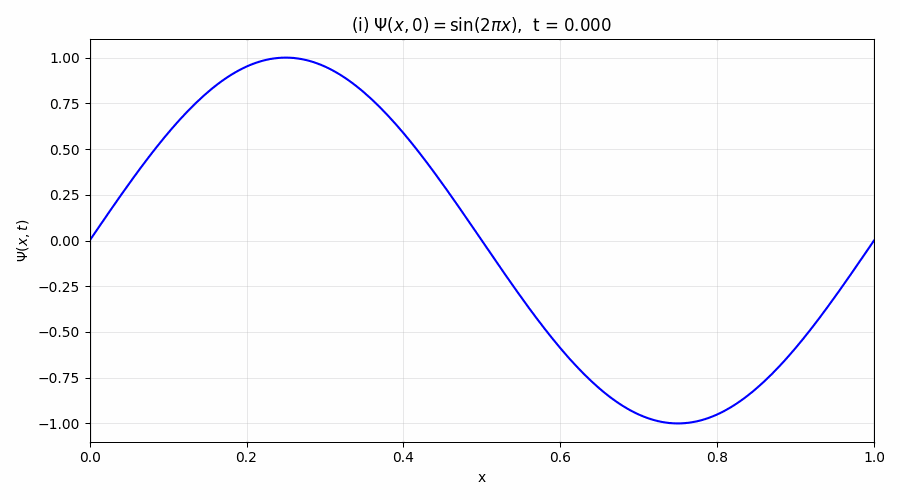

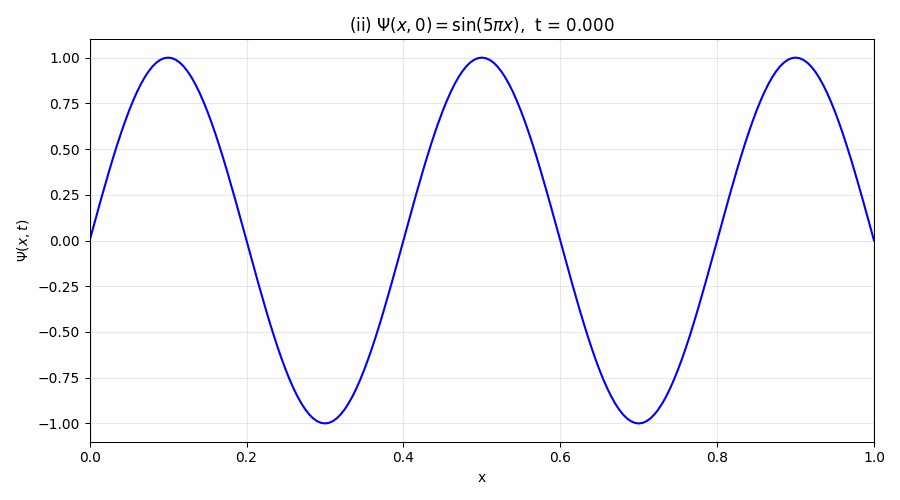

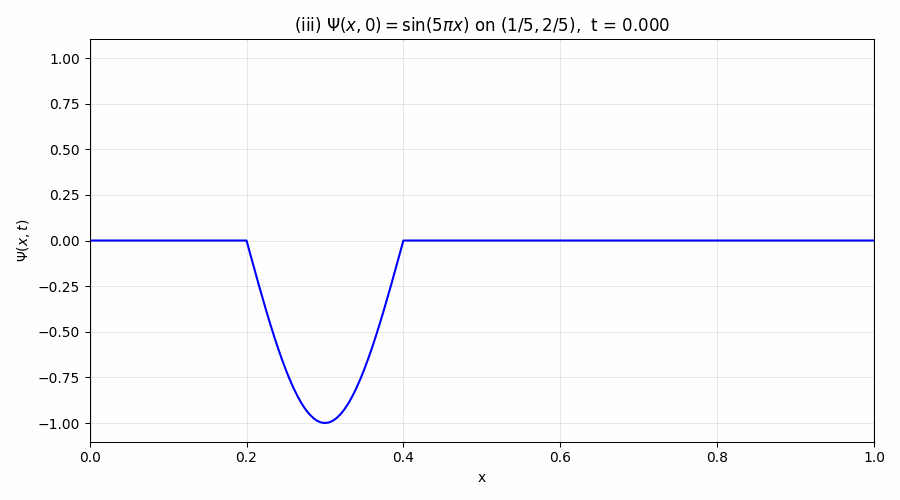

In [31]:
for t_list, s_list, title, name in cases:
    ymax = max(np.max(np.abs(s)) for s in s_list)*1.1
    
    f = []
    s = 20
    for n in range(0,len(s_list),s):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.plot(x, s_list[n], 'b-')
        ax.set_xlim(0, L)
        ax.set_ylim(-ymax, ymax)
        ax.set_xlabel("x")
        ax.set_ylabel(r"$\Psi(x,t)$")
        ax.set_title(f"{title},  t = {t_list[n]:.3f}")
        ax.grid(alpha=0.3)
        plt.tight_layout()
        
        buf = io.BytesIO()
        fig.savefig(buf, format='png', dpi=100)
        plt.close()
        buf.seek(0)
        f.append(PILImage.open(buf).copy())
        buf.close()
    
    gif_buf = io.BytesIO()
    f[0].save(gif_buf, format='GIF', save_all=True, append_images=f[1:], duration=100, loop=0)
    gif_buf.seek(0)
    display(Image(data=gif_buf.getvalue()))

### Bonus/Optional Question


In [46]:
def lap(psi, dx):
    lap_psi = np.zeros_like(psi)
    lap_psi[1:-1]=(psi[2:]+psi[:-2]-2*psi[1:-1])/dx**2
    return lap_psi

def leap(psi0,v0,c,dx,dt,T):
    psi=np.copy(psi0)
    v=np.copy(v0)
    v_h = v + 0.5*dt*c**2*lap(psi,dx)
    t=0
    times=[0]
    states=[np.copy(psi)]
    vhs=[np.copy(v_h)]
    
    while t<T:
        psi+=dt*v_h
        psi[0]=0
        psi[-1]=0
        v_h+=dt*c**2*lap(psi, dx)
        
        t+=dt
        times.append(t)
        states.append(np.copy(psi))
        vhs.append(np.copy(v_h))
    
    return times, states, vhs

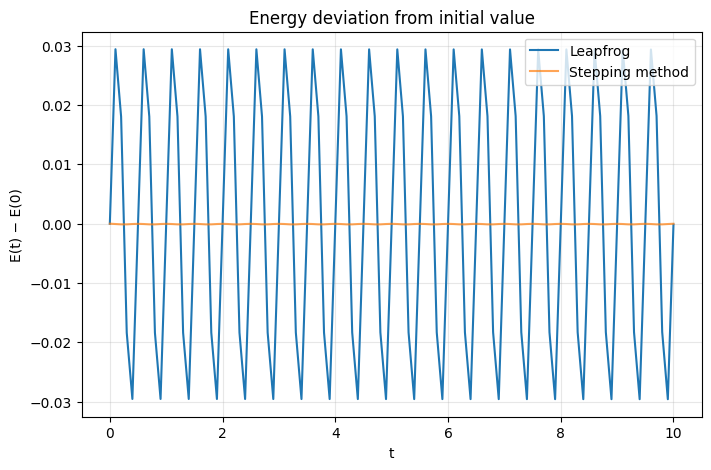

In [47]:
def energy(psi, v_h, c, dx):
    ke = 0.5 * np.sum(v_h[1:-1]**2) * dx
    pe = 0.5 * c**2 * dx * np.sum(((psi[1:] - psi[:-1]) / dx)**2)
    return ke + pe

psi0=np.sin(2*np.pi*x)
v0=np.zeros(N+1)

T=10
t_lf, s_lf, v_lf = leap(psi0, v0, c, dx, dt, T)
t_st, s_st = wav(psi0, T, dt, dx, c)

e_lf=[energy(s_lf[i], v_lf[i], c, dx) for i in range(len(t_lf))]
e_st=[energy(s_st[i],(s_st[min(i+1,len(s_st)-1)]-s_st[max(i-1,0)])/(2*dt), c, dx) for i in range(len(t_st))]

E0_lf = e_lf[0]
E0_st = e_st[0]

plt.figure(figsize=(8, 5))
plt.plot(t_lf[::100], [(e - E0_lf) for e in e_lf[::100]], label='Leapfrog')
plt.plot(t_st[::100], [(e - E0_st) for e in e_st[::100]], label='Stepping method', alpha=0.7)
plt.xlabel('t')
plt.ylabel('E(t) − E(0)')
plt.title('Energy deviation from initial value')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


### Exercise 1.2

In [10]:
import numpy as np
import matplotlib.pyplot as plt
# import os
from scipy.special import erfc
import io
from PIL import Image as PILImage
from IPython.display import Image as IPImage, display

In [11]:
# parameters
N=50
D=1
dx=1/N
dt=dx**2/(4*D)*0.9
x=np.linspace(0,1,N+1)
y=np.linspace(0,1,N+1)
# initial conditions
c=np.zeros((N+1,N+1))
c[:,N]=1
c[N,:]=0

In [12]:
# boundary conditions
def bc(c):
    c[:,N]=1
    c[:,0]=0
    c[0,:]=c[N-1,:]
    c[N,:]=c[1,:]

# diffusion step  
def step(c,dt,dx,D):
    c_n = np.copy(c)
    r=D*dt/dx**2
    for i in range(1,N):
        for j in range(1,N):
            c_n[i,j]=c[i,j]+r*(c[i+1,j]+c[i-1,j]+c[i,j+1]+c[i,j-1]-4*c[i,j])
    bc(c_n)
    return c_n
    

In [13]:
# simulation loop
snap_times = [0, 0.001, 0.01, 0.1, 1.0]
snaps = {}
snaps[0] = np.copy(c)

t=0
T_end=1
snap_idx=1
step_co=0

# loop for diffusion simulation 
while t<T_end:
    c=step(c,dt,dx,D)
    t+=dt
    step_co+=1
    
    # if step_co%100 ==0:
    #     np.savetxt(os.path.join(data_dir, f"c_step_{step_co:06d}.npy"), c)

    if snap_idx<len(snap_times) and t>=snap_times[snap_idx]:
        snaps[snap_times[snap_idx]]=np.copy(c)
        snap_idx+=1

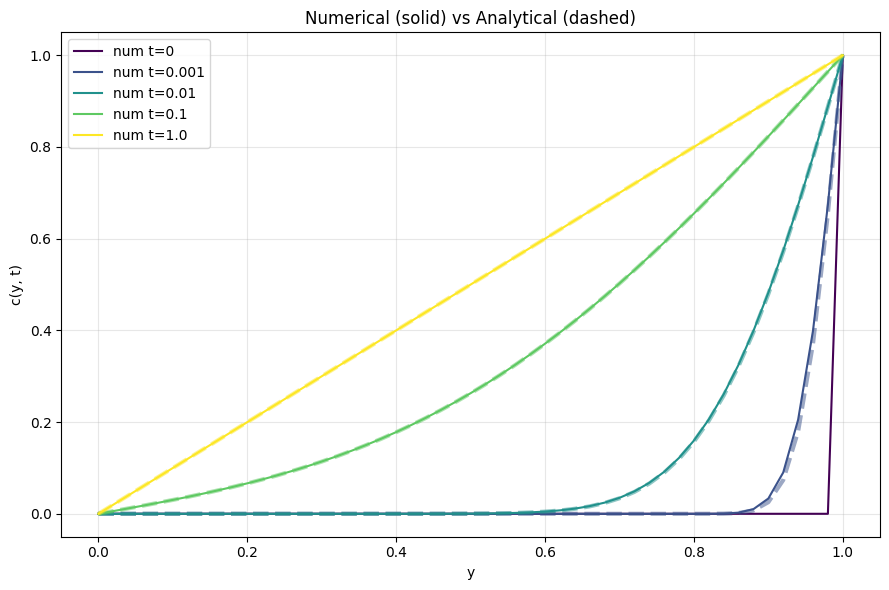

In [14]:
def analytical(y_vals, t):
    if t<=0:
        return np.zeros_like(y_vals)
    res=np.zeros_like(y_vals)
    for i in range(50):
        res+=(erfc((1 - y_vals + 2*i)/(2*np.sqrt(D*t)))-erfc((1 + y_vals + 2*i)/(2*np.sqrt(D*t))))
    return res

fig, ax = plt.subplots(figsize=(9, 6))
col_e = plt.cm.viridis(np.linspace(0, 1, len(snap_times)))
mid = N//2

for k, t_snap in enumerate(snap_times):
    if t_snap not in snaps:
        continue
    
    num=snaps[t_snap][mid, :]
    
    if t_snap>0:
        ana=analytical(y, t_snap)
        ax.plot(y, ana, '--', color=col_e[k], linewidth=3, alpha=0.5)
    
    ax.plot(y, num, '-', color=col_e[k], linewidth=1.5, label=f"num t={t_snap}")

ax.set_xlabel("y")
ax.set_ylabel("c(y, t)")
ax.set_title("Numerical (solid) vs Analytical (dashed)")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
# plt.savefig(os.path.join(out_dir, "part_e.png"), dpi=150)

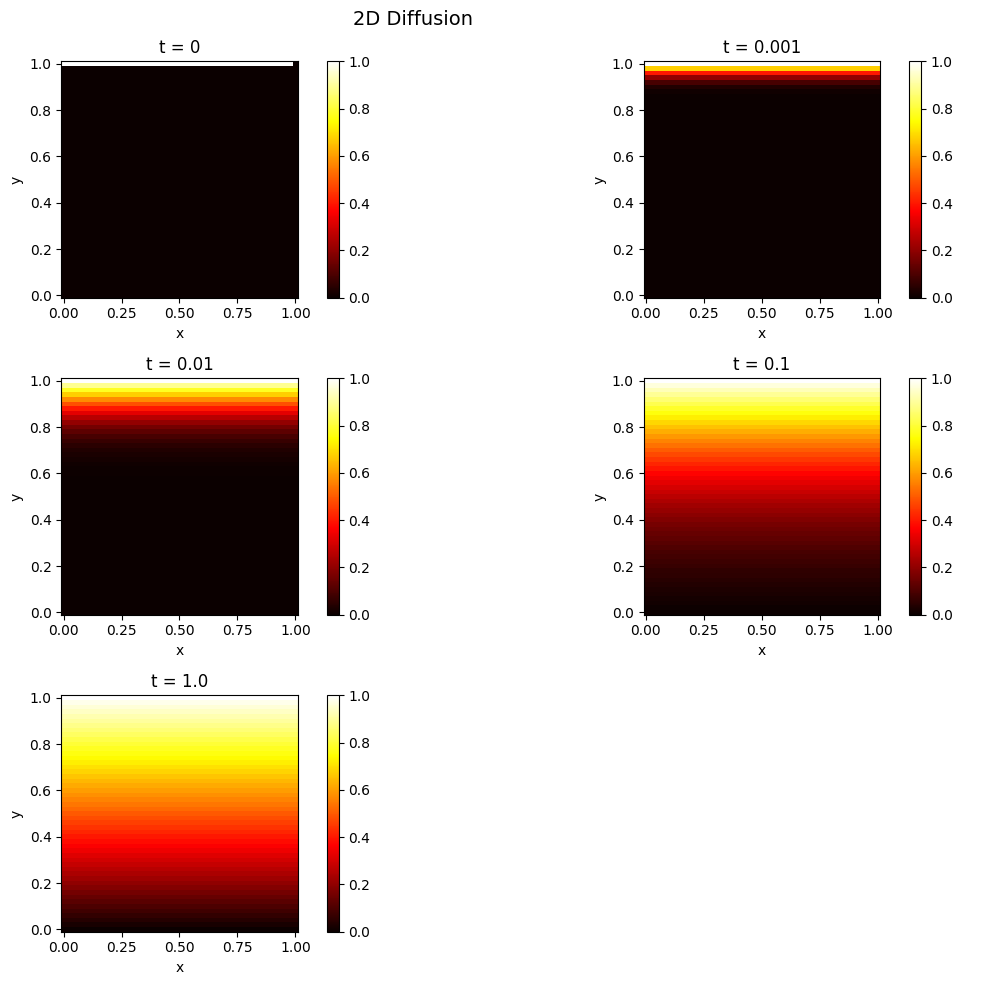

In [15]:
X, Y = np.meshgrid(x, y, indexing='ij')

fig, axs = plt.subplots(3, 2, figsize=(12, 10))
axes = axs.flatten()

for k, t_s in enumerate(snap_times):
    if t_s not in snaps:
        continue
    ax = axes[k]
    im = ax.pcolormesh(X, Y, snaps[t_s], vmin=0, vmax=1, cmap='hot')
    ax.set_title(f"t = {t_s}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect('equal')
    fig.colorbar(im, ax=ax)

axes[-1].axis('off')
plt.suptitle("2D Diffusion", fontsize=14)
plt.tight_layout()
# plt.savefig(os.path.join(out_dir, "part_f.png"), dpi=150)
plt.show()

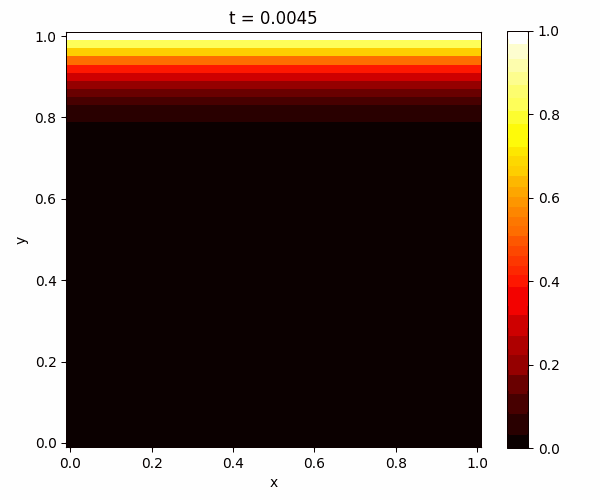

In [16]:
# resetting initial conditions for animation
c=np.zeros((N+1, N+1))
c[:, N]=1
c[:, 0]=0
bc(c)
# animation loop with convergence check
t=0
f=[]
s_freq=50
s_co=0
tol=1e-6

while True:
    c_old = np.copy(c)
    c = step(c, dt, dx, D)
    t += dt
    s_co += 1
    # saving frames at specified frequency
    if s_co%s_freq==0:
        fig, ax = plt.subplots(figsize=(6, 5))
        im = ax.pcolormesh(X, Y, c, vmin=0, vmax=1, cmap='hot')
        ax.set_title(f"t = {t:.4f}")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_aspect('equal')
        fig.colorbar(im, ax=ax)
        plt.tight_layout()
        buf = io.BytesIO()
        fig.savefig(buf, format='png', dpi=100)
        plt.close()
        buf.seek(0)
        f.append(PILImage.open(buf).copy())
        buf.close()
    # checking for convergence
    max_change = np.max(np.abs(c - c_old))
    if max_change < tol:
        fig, ax = plt.subplots(figsize=(6, 5))
        im = ax.pcolormesh(X, Y, c, vmin=0, vmax=1, cmap='hot')
        ax.set_title(f"equilibrium, t = {t:.4f}")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_aspect('equal')
        fig.colorbar(im, ax=ax)
        plt.tight_layout()
        buf = io.BytesIO()
        fig.savefig(buf, format='png', dpi=100)
        plt.close()
        buf.seek(0)
        f.append(PILImage.open(buf).copy())
        buf.close()
        break

gif_buf = io.BytesIO()
f[0].save(gif_buf, format='GIF', save_all=True, append_images=f[1:], duration=50, loop=0)
gif_buf.seek(0)
display(IPImage(data=gif_buf.getvalue()))

### Exercise 1.3 - Part H to J

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
# import os

######################
N=50
eps=1e-5
y=np.linspace(0,1,N+1)

### Jacobi iteration

In [18]:
@njit
def jacobi(N, eps):
    c=np.zeros((N+1,N+1))
    c[:,N]=1
    c_n=np.zeros_like(c)
    dels=[]
    k=0
    
    while True:
        for i in range(N):
            ip=(i+1)%N
            im=(i-1)%N
            for j in range(1,N):
                c_n[i,j]=0.25*(c[ip,j]+c[im,j]+c[i,j+1]+c[i,j-1])
                
        c_n[:,0]=0
        c_n[:,N]=1
        
        d=np.max(np.abs(c_n-c))
        dels.append(d)
        
        c[:,:]=c_n
        k+=1
        
        if d<eps:
            break
    return c, dels, k

### Gauss-Siedel

In [19]:
@njit 
def seidel(N, eps):
    c=np.zeros((N+1,N+1))
    c[:,N]=1
    dels=[]
    k=0
    
    while True:
        d=0
        
        for i in range(N):
            ip=(i+1)%N
            im=(i-1)%N
            for j in range(1,N):
                old= c[i,j]
                c[i,j]=0.25*(c[ip,j]+c[im,j]+c[i,j+1]+c[i,j-1])
                d=max(d, abs(c[i,j]-old))
                
        c[:,0]=0
        c[:,N]=1
        dels.append(d)
        k+=1
        
        if d<eps:
            break
        
    return c,dels,k


### SOR

In [20]:
@njit
def sor(N, eps, omega):
    c=np.zeros((N+1,N+1))
    c[:,N]=1
    dels=[]
    k=0
    
    while True:
        d=0
        
        for i in range(N):
            ip=(i+1)%N
            im=(i-1)%N
            for j in range(1,N):
                old=c[i,j]
                gs=0.25*(c[ip,j]+c[im,j]+c[i,j+1]+c[i,j-1])
                c[i,j]=(1-omega)*old + omega*gs
                d=max(d,abs(c[i,j]-old))
        
        c[:,0]=0
        c[:,N]=1
        
        dels.append(d)
        k+=1
        
        if d<eps:
            break
    
    return c,dels,k

In [21]:
def plot_sol(c, name):
    mid=N//2
    plt.figure(figsize=(6,5))
    plt.plot(y, c[mid, :], 'b-', label='numerical')
    plt.plot(y, y, 'r--', label='c = y')
    plt.xlabel('y')
    plt.ylabel('c')
    plt.title(f"{name} (N={N})")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    # plt.savefig(os.path.join(out_dir, fname), dpi=150)
    # plt.close()
    plt.show()
    
def plot_conv(curves):
    plt.figure(figsize=(8,6))
    for lbl, d in curves.items():
        plt.semilogy(range(1, len(d)+1), d, label=lbl)

    plt.xlabel('Iteration k')
    plt.ylabel('δ')
    plt.title('Convergence')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    # plt.savefig(os.path.join(out_dir, fname), dpi=150)
    # plt.close()
    plt.show()
    
def plot_opt(omegas, iters):
    b_idx=np.argmin(iters)
    b_omega=omegas[b_idx]
    b_iters=iters[b_idx]

    plt.figure(figsize=(7,5))
    plt.plot(omegas, iters, 'bo-', label='iterations')
    plt.plot(b_omega, b_iters, 'ro', markersize=8, label=f'optimal ω = {b_omega:.2f}')
    plt.axvline(b_omega, color='r', linestyle='--')

    plt.annotate(
        f'ω* = {b_omega:.2f}\n{b_iters} iterations',
        xy=(b_omega, b_iters),
        xytext=(b_omega + 0.05, b_iters * 1.1),
        arrowprops=dict(arrowstyle="->")
    )

    plt.xlabel('ω')
    plt.ylabel('Iterations')
    plt.title('SOR: Iterations vs ω')
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    # plt.savefig(os.path.join(out_dir, "part_j.png"), dpi=150)
    # plt.close()
    plt.show()

    print(f"Optimal ω = {b_omega:.3f}, iterations = {b_iters}")

In [22]:
def test(c, name):
    mid=N//2
    num = c[mid, :]
    analytic = y

    max_err = np.max(np.abs(num - analytic))
    l2_err = np.sqrt(np.mean((num - analytic)**2))

    print(f"{name}:")
    print(f"  max error = {max_err:.3e}")
    print(f"  L2 error  = {l2_err:.3e}")
    print()

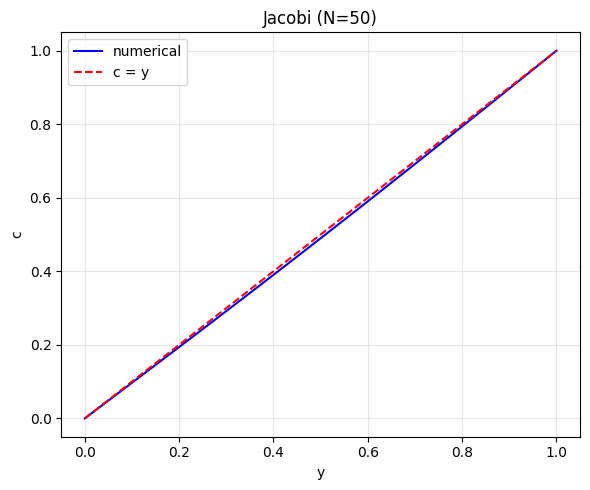

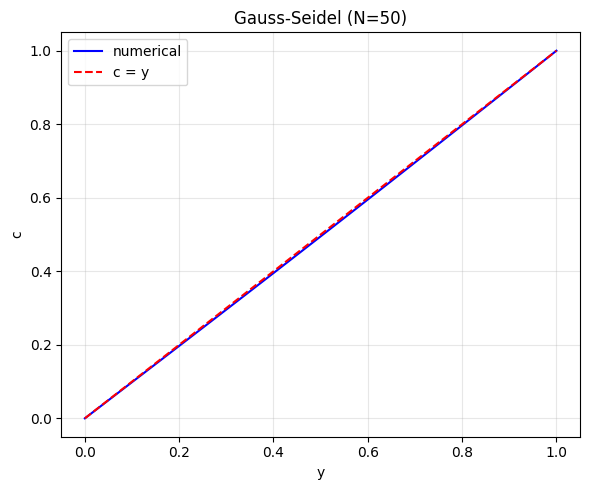

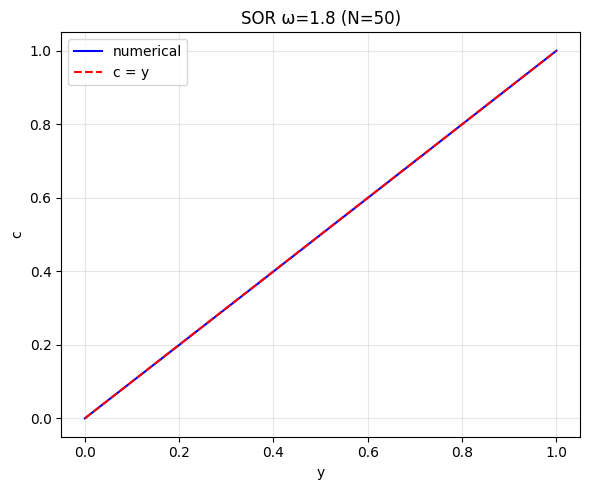

Jacobi:
  max error = 1.012e-02
  L2 error  = 7.088e-03

Gauss-Seidel:
  max error = 5.055e-03
  L2 error  = 3.539e-03

SOR:
  max error = 5.327e-04
  L2 error  = 3.717e-04



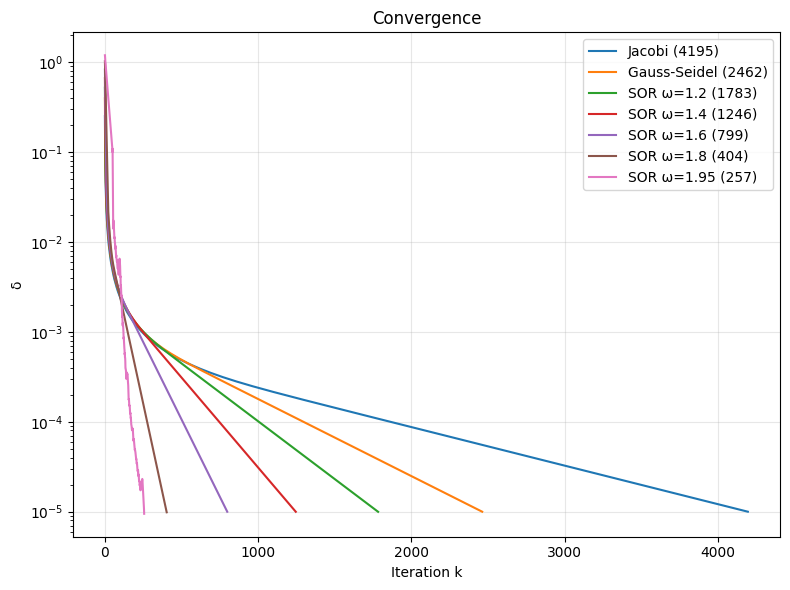

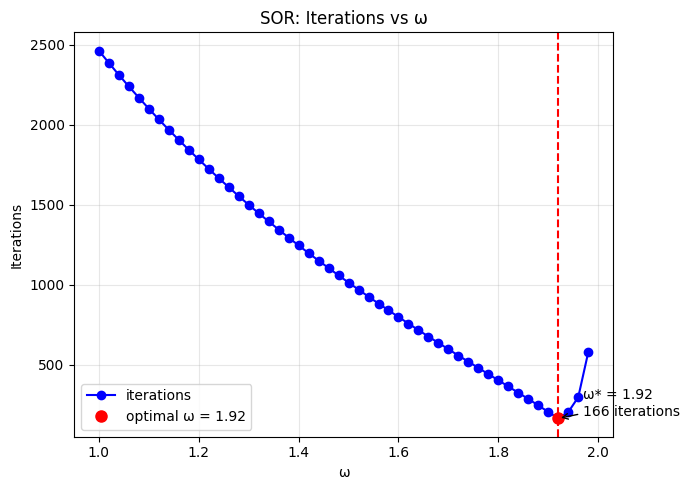

Optimal ω = 1.920, iterations = 166


In [23]:
c_j, d_j, k_j = jacobi(N, eps)
c_g, d_g, k_g = seidel(N, eps)
c_s1, d_s1, k_s1 = sor(N, eps, 1.2)
c_s2, d_s2, k_s2 = sor(N, eps, 1.4)
c_s3, d_s3, k_s3 = sor(N, eps, 1.6)
c_s4, d_s4, k_s4 = sor(N, eps, 1.8)
c_s5, d_s5, k_s5 = sor(N, eps, 1.95)    

plot_sol(c_j, "Jacobi")
plot_sol(c_g, "Gauss-Seidel")
plot_sol(c_s4, "SOR ω=1.8")
test(c_j, "Jacobi")
test(c_g, "Gauss-Seidel")
test(c_s4, "SOR")

plot_conv({
    f'Jacobi ({k_j})': d_j,
    f'Gauss-Seidel ({k_g})': d_g,
    f'SOR ω=1.2 ({k_s1})': d_s1,
    f'SOR ω=1.4 ({k_s2})': d_s2,
    f'SOR ω=1.6 ({k_s3})': d_s3,
    f'SOR ω=1.8 ({k_s4})': d_s4,
    f'SOR ω=1.95 ({k_s5})': d_s5
})

omegas = np.arange(1.0, 2.0, 0.02)
iters = []

for w in omegas:
    _, _, k = sor(N, eps, w)
    iters.append(k)

plot_opt(omegas, iters)

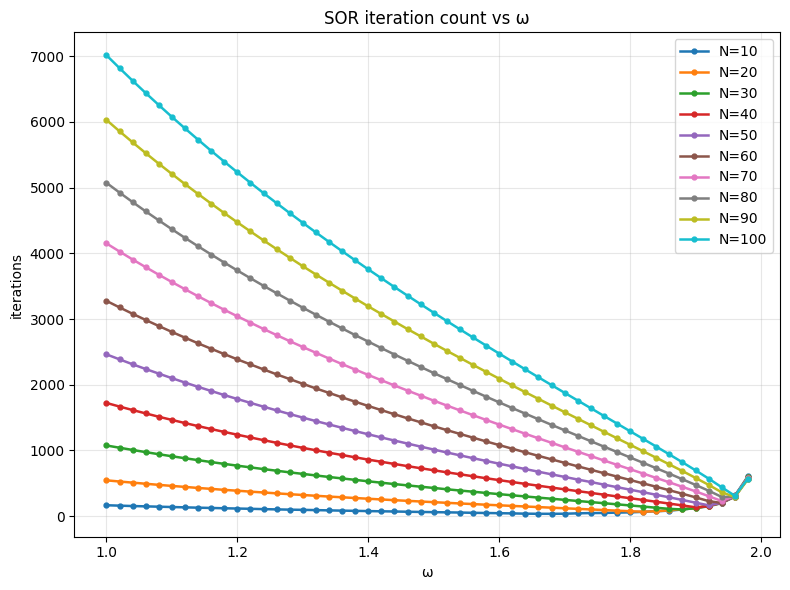

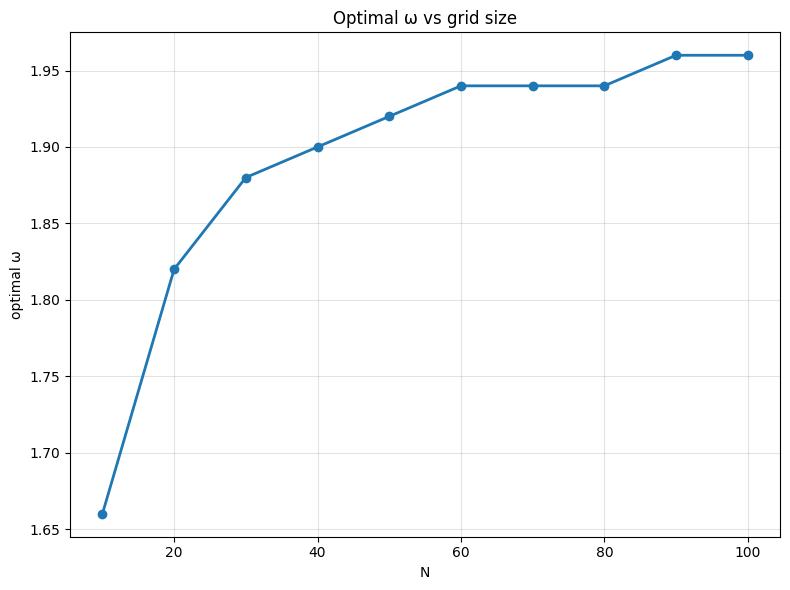

  N= 10: ω_opt=1.66, iters=37
  N= 20: ω_opt=1.82, iters=69
  N= 30: ω_opt=1.88, iters=103
  N= 40: ω_opt=1.90, iters=136
  N= 50: ω_opt=1.92, iters=166
  N= 60: ω_opt=1.94, iters=201
  N= 70: ω_opt=1.94, iters=231
  N= 80: ω_opt=1.94, iters=293
  N= 90: ω_opt=1.96, iters=293
  N=100: ω_opt=1.96, iters=311


In [24]:
N_vals = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
o_vals = np.arange(1.0, 2.0, 0.02)

b_omega = []
b_iters = []
all_iters = {}

for n in N_vals:
    iters_n = []
    for w in o_vals:
        _, _, k = sor(n, eps, w)
        iters_n.append(k)
    all_iters[n] = iters_n
    b_idx = np.argmin(iters_n)
    b_omega.append(o_vals[b_idx])
    b_iters.append(iters_n[b_idx])

# iterations vs omega for each N
plt.figure(figsize=(8, 6))
for n in N_vals:
    plt.plot(o_vals, all_iters[n], marker='o', ms=3.5, lw=1.8, label=f'N={n}')
plt.xlabel('ω')
plt.ylabel('iterations')
plt.title('SOR iteration count vs ω')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# optimal omega vs N
plt.figure(figsize=(8, 6))
plt.plot(N_vals, b_omega, marker='o', lw=2.0)
plt.xlabel('N')
plt.ylabel('optimal ω')
plt.title('Optimal ω vs grid size')
plt.grid(alpha=0.35)
plt.tight_layout()
plt.show()

for n, w, k in zip(N_vals, b_omega, b_iters):
    print(f'  N={n:3d}: ω_opt={w:.2f}, iters={k}')